# DrugShot
DrugShot searches PubMed for articles that co-mention any search term and terms that describe drugs.

It then prioritizes the top literature associated drugs and predicts additional drugs based on shared properties in drug-drug similarity matrices.

In [1]:
from collections import Counter

import pandas as pd
import numpy as np

# Display / graphing
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# API access
import requests
import io
import time
import json

In [2]:
# Notebook display util functions
def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

table_number = 0
figure_number = 0
def figure_header(label,title):
    global table_number
    global figure_number
    if label == 'Table':
        table_number += 1
        label = f'Table {table_number}'
    elif label == 'Figure':
        figure_number += 1
        label = f'Figure {figure_number}'
    display(HTML(f"<div style='font-size:1.25rem; padding:1rem 0;'><b>{label}</b>: {title}</div>"))
    
def figure_legend(label,title,content=''):
    global table_number
    global figure_number
    if label == 'Table':
        label = f'Table {table_number}'
    elif label == 'Figure':
        label = f'Figure {figure_number}'
    display(HTML(f'<style>div.caption {{text-align: center;}}</style><div class=caption><b>{label}</b>: <i>{title}</i>. {content} </div>'))
    
def drugenrichr_link(short_id):
    display(HTML(f'<span><a href="https://maayanlab.cloud/DrugEnrichr/enrich?dataset={short_id}">Access the complete enrichment analysis on the DrugEnrichr website. </a></span>'))

In [3]:
def DrugEnrichr_API(drug_list, description):
    # takes a drug list and provides a shortID to view enrichment analysis results on DrugEnrichr website
    global short_id
    DRUG_ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/addList'
    drugs_str = '\n'.join(drug_list)
    payload = {
        'list': (None, drugs_str),
        'description': (None, description)
    }

    response = requests.post(DRUG_ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing drug list')

    data = json.loads(response.text)
    short_id = data['shortId']
    user_list_id = data['userListId']

    #sends generated userListId to DrugEnrichr enrichment API endpoint
    results = {}
    DRUG_ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    for drug_set_library in ['L1000FWD_GO_Biological_Processes_Up', 'L1000FWD_GO_Biological_Processes_Down',
                   'SIDER_Side_Effects']:
        response = requests.get(
            DRUG_ENRICHR_URL + query_string % (user_list_id, drug_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
            
        data = response.json()[drug_set_library]
        try:
            short_results_df  = pd.DataFrame(data).sort_values(by = [2])
            results[drug_set_library] = {
                'terms': short_results_df[1].head(10).tolist(),
                'p-values': short_results_df[2].head(10).tolist(),
                'adjusted p-values': short_results_df[6].head(10).tolist()
            }
        except KeyError:
            pass
        
    return results
            
        
# Create bar plot of top 10 enriched terms in L1000FWD & SIDER libraries
def bar_plot(results): 
    # Bar colors
    bar_color = 'pink'
    bar_color_not_sig = 'lightgrey'
    edgecolor=None
    linewidth=0    

    for library, values in results.items():
        plt.figure(figsize=(24, 12))
        bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in values['p-values']]
        fig = sns.barplot(x=np.log10(values['p-values'])*-1,
                          y= values['terms'],
                          palette=bar_colors,
                          edgecolor=edgecolor,
                          linewidth=linewidth)

        fig.axes.get_yaxis().set_visible(False)
        fig.set_title(library.replace('_', ' '), fontsize=26)
        fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
        fig.xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tick_params(axis='x', which='major', labelsize=20)
        if max(np.log10(results[library]['p-values'])*-1)<1:
            fig.xaxis.set_ticks(np.arange(0, max(np.log10(results[library]['p-values'])*-1), 0.1))
        for index,term in enumerate(results[library]['terms']):
            if results[library]['adjusted p-values'][index] < 0.05:
                term = '  *'.join([term,
                                    str(str(np.format_float_scientific(results[library]['p-values'][index],
                                    precision=2)))]) 
            else:
                term = '  '.join([term,
                                   str(str(np.format_float_scientific(results[library]['p-values'][index],
                                   precision=2)))])

            title_start= max(fig.axes.get_xlim())/200
            fig.text(title_start, index, term, ha='left', wrap = True, fontsize = 26)

        fig.spines['right'].set_visible(False)
        fig.spines['top'].set_visible(False)
        plt.show()

In [4]:
matrix_files = {'L1000 Signature Similarity': 'https://appyters.maayanlab.cloud/storage/DrugShot/L1000_similarity_matrix.npz',
                'AutoRIF Literature Co-mentions': 'https://appyters.maayanlab.cloud/storage/DrugShot/AutoRIF_cooccurence_matrix.tsv.gz',
                'DrugRIF Literature Co-mentions' : 'https://appyters.maayanlab.cloud/storage/DrugShot/DrugRIF_cooccurence_matrix.tsv.gz'
                }


### Load AutoRIF


In [5]:
RIF = pd.read_csv("https://appyters.maayanlab.cloud/storage/DrugShot/AutoRIF.tsv.gz",
                      sep = '\t',
                      usecols = ['name','PMID']).set_index('name')


### Query Term Using PubMed Eutils API


In [1]:
i = 0
results = []
pubmed_url = ("https://eutils.ncbi.nlm.nih.gov/entrez"+
             "/eutils/esearch.fcgi"+
             "?db=pubmed&term={}"+
             "&retmax=100000"+
             "&retstart={}"+
             "&retmode=json")
res = requests.get(pubmed_url.format('Irritable Bowel Syndrome', i)).json()
if int(res['esearchresult']['count']) > 0:
    while i <= int(res['esearchresult']['count']):
        results.extend(requests.get(pubmed_url.format('Irritable Bowel Syndrome',i)).json()['esearchresult']['idlist'])
        i += len(res['esearchresult']['idlist'])
        time.sleep(0.2)
results = list(map(int, results))

NameError: name 'requests' is not defined


### Associated Drug Table


In [7]:
# Retrieve associated drugs based on drug:search term co-mentions in the literature
df_associated = pd.DataFrame(RIF[RIF['PMID'].isin(results) == True].index.value_counts())\
.rename(columns = {'name':'Publications with Search Term'})
# Get counts of each drug in the association file
drug_counts = Counter(RIF[RIF.index.isin(df_associated.index)].index)
# Calculate fraction of publications associated with drug+term / drug only
normalized_fraction = [(df_associated.loc[index][0]/drug_counts[index]) for index in df_associated.index]
df_associated['Publications with Search Term / Total Publications'] = normalized_fraction
# Calculate (Publications with Search Term * Normalized Fraction) used as metric to rank unweighted drug set",
df_associated['Publications with Search Term * Normalized Fraction'] = df_associated['Publications with Search Term'] * df_associated['Publications with Search Term / Total Publications']
del(RIF)

In [8]:
associated_table = df_associated.sort_values(by = ['Publications with Search Term'], ascending = False)
associated_table.to_csv('Lung Cancer'.replace(' ','_')+'_associated_drug_table.csv')
figure_header('Table', 'Top Associated Compounds<br>({})</br>'.format(make_clickable('Lung Cancer'.replace(' ','_')+'_associated_drug_table.csv')))
display(associated_table[associated_table.columns[0:2]].head(20))
figure_legend('Table', 'Top 20 Drugs associated with '+'Lung Cancer')
del(df_associated)

Publications with Search Term  \
cisplatin                                  9602   
daunorubicin                               4510   
doxorubicin                                4342   
paclitaxel                                 4219   
cyclophosphamide                           3994   
podophyllotoxin                            3509   
etoposide                                  3398   
carboplatin                                3397   
gefitinib                                  3178   
fluorouracil                               2812   
erlotinib                                  2684   
gemcitabine                                2655   
docetaxel                                  2286   
vinblastine                                2211   
camptothecin                               1824   
vincristine                                1715   
aminopterin                                1612   
pemetrexed                                 1607   
methotrexate                               1560   
vinorelbine                                1449   

                  Publications with Search Term / Total Publications  
cisplatin                                                  0.176138   
daunorubicin                                               0.066277   
doxorubicin                                                0.072220   
paclitaxel                                                 0.148766   
cyclophosphamide                                           0.072459   
podophyllotoxin                                            0.185240   
etoposide                                                  0.198481   
carboplatin                                                0.279037   
gefitinib                                                  0.676746   
fluorouracil                                               0.058144   
erlotinib                                                  0.652724   
gemcitabine                                                0.228505   
docetaxel                                                  0.203164   
vinblastine                                                0.173903   
camptothecin                                               0.124175   
vincristine                                                0.071911   
aminopterin                                                0.040021   
pemetrexed                                                 0.721923   
methotrexate                                               0.039733   
vinorelbine                                                0.523672


### Scatter Plot of Drug Frequency in Literature


In [9]:
fig = px.scatter(associated_table.reset_index().rename(columns = {'index':'chemical'}),
                 x = 'Publications with Search Term',
                 y = 'Publications with Search Term / Total Publications',
                 hover_name = 'chemical',
                 title='Lung Cancer')
fig.show()


Create list of top associated compounds ranked by **Publications with Search Term * Normalized Fraction** to treat as an unweighted drug set for further predictions


In [10]:
associated_compounds = associated_table.sort_values(by = 'Publications with Search Term * Normalized Fraction',
                                                    kind = 'stable',
                                                    ascending = False)[0:20].index.str.upper().tolist()

### Predicted Drugs From L1000 Signature Similarity
Predicted compounds are computed based on average similarity between the unweighted drug set and other drugs & small molecules within the **L1000 Signature Similarity** matrix

In [11]:
# Load correlation matrix into pandas DataFrame
response = requests.get(matrix_files["L1000 Signature Similarity"])
coexpression_matrix = np.load(io.BytesIO(response.content), allow_pickle = True)
mat = pd.DataFrame(data = coexpression_matrix['correlations'], columns = coexpression_matrix['index'],
                               index = coexpression_matrix['index'])
del(coexpression_matrix)

In [12]:
# Calculate average similarity for each drug in the prediction matrix with the associated drug set
mat = mat.loc[mat.index.str.upper().isin(associated_compounds)]
print(f'{len(mat.index)} small molecules from the associated drug set matched in the similarity matrix')
mat.loc['Similarity_Score'] = mat[mat.columns].mean()
mat.sort_values(by = ['Similarity_Score'], axis = 1, ascending = False, inplace = True)

17 small molecules from the associated drug set matched in the similarity matrix


In [13]:
# Calculating FPR and TPR for literature co-mentions predictions
y_score = mat.loc['Similarity_Score'].sort_values(ascending = False)
true_indices = sorted([y_score.\
                       index.str.upper().\
                       get_loc(x) for x in associated_compounds \
                       if x in mat.index.str.upper()])
y_true = np.zeros(len(mat.columns))
np.put(y_true, true_indices, 1)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
auc_score = sklearn.metrics.roc_auc_score(y_true, y_score)
# Plot dataframe
data = pd.DataFrame(data=[y_score.index,y_true,fpr,tpr],
                   index = ['name','label','fpr','tpr']).T
# ROC Curve
fig = go.Figure()
name = f"(AUC={auc_score:.4f})"
fig.add_trace(go.Scatter(x=data['fpr'],
                         y=data['tpr'],
                         text = data['name'],
                         showlegend=True,
                         name=name,
                         mode='lines'))
fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,
    x1=1,
    y0=0,
    y1=1)
fig.layout.update(
    title = f'ROC Curve for Unweighted Drug Set Rankings in L1000 Signature Similarity Matrix',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=0.65),
    xaxis=dict(constrain='domain'),
    width=800, height=500
)
fig.show()

In [14]:
predicted_table = pd.DataFrame(mat.loc['Similarity_Score'])
predicted_table = predicted_table[~predicted_table.index.str.upper().isin(associated_compounds)]
filename = 'Lung Cancer'.replace(' ','_')+"_L1000 Signature Similarity".replace(' ','_')+'_predicted_drug_table.csv'
predicted_table.to_csv(filename)
predicted_table.to_csv(filename)
figure_header('Table', 'Top Predicted Compounds From L1000 Signature Similarity<br>({})</br>'.format(make_clickable(filename)))
display(predicted_table.head(20))
figure_legend('Table', 'Top 20 drugs predicted to be associated with {0} based on {1}'.format('Lung Cancer','L1000 Signature Similarity'))

Similarity_Score
BIX-01294              0.219085
purvalanol-a           0.216146
BRD-K40329609          0.208855
MG-132                 0.202497
SIB-1893               0.198807
avicin-d               0.198806
TL-HRAS-61             0.197671
TL-HRAS-24             0.196999
staurosporine          0.191676
triptolide             0.190192
BRD-K30351863          0.189929
7b-cis                 0.188961
SA-25547               0.188509
PD-184352              0.187928
BG-1024                0.186603
BRD-K29506255          0.185905
BRD-K56411643          0.185891
KIN001-055             0.185872
SB-590885              0.184723
neratinib              0.184069

### DrugEnrichr Analysis of L1000 Signature Similarity Predicted Drugs
The top 50 predicted small molecules are submitted for drug set enrichment analysis using DrugEnrichr
<br><br>
The output bar charts show the top 10 enriched terms in each library, along with their corresponding p-values. Colored bars correspond to terms with significant p-values (<0.05). An asterisk (*) next to a p-value indicates the term also has a significant adjusted p-value (<0.05).

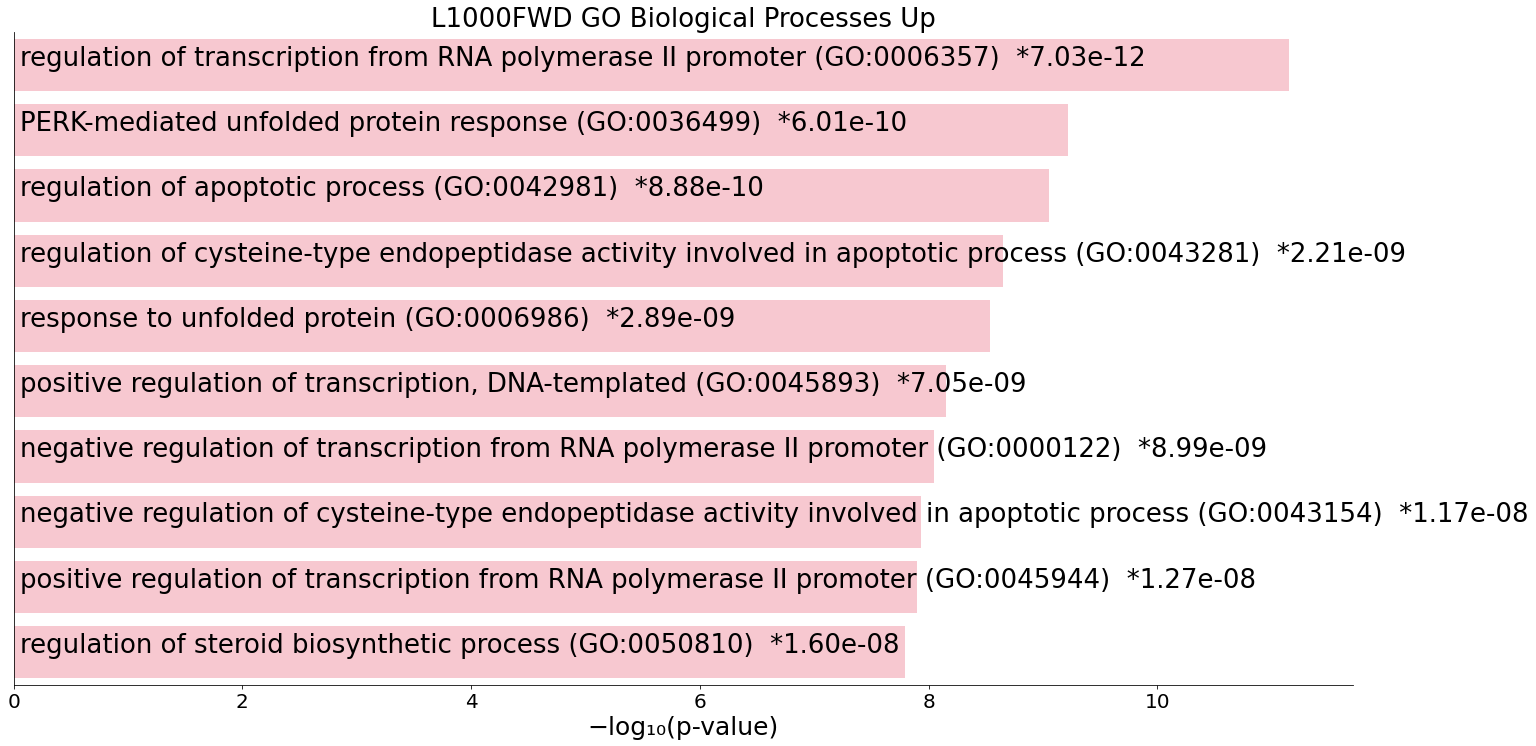

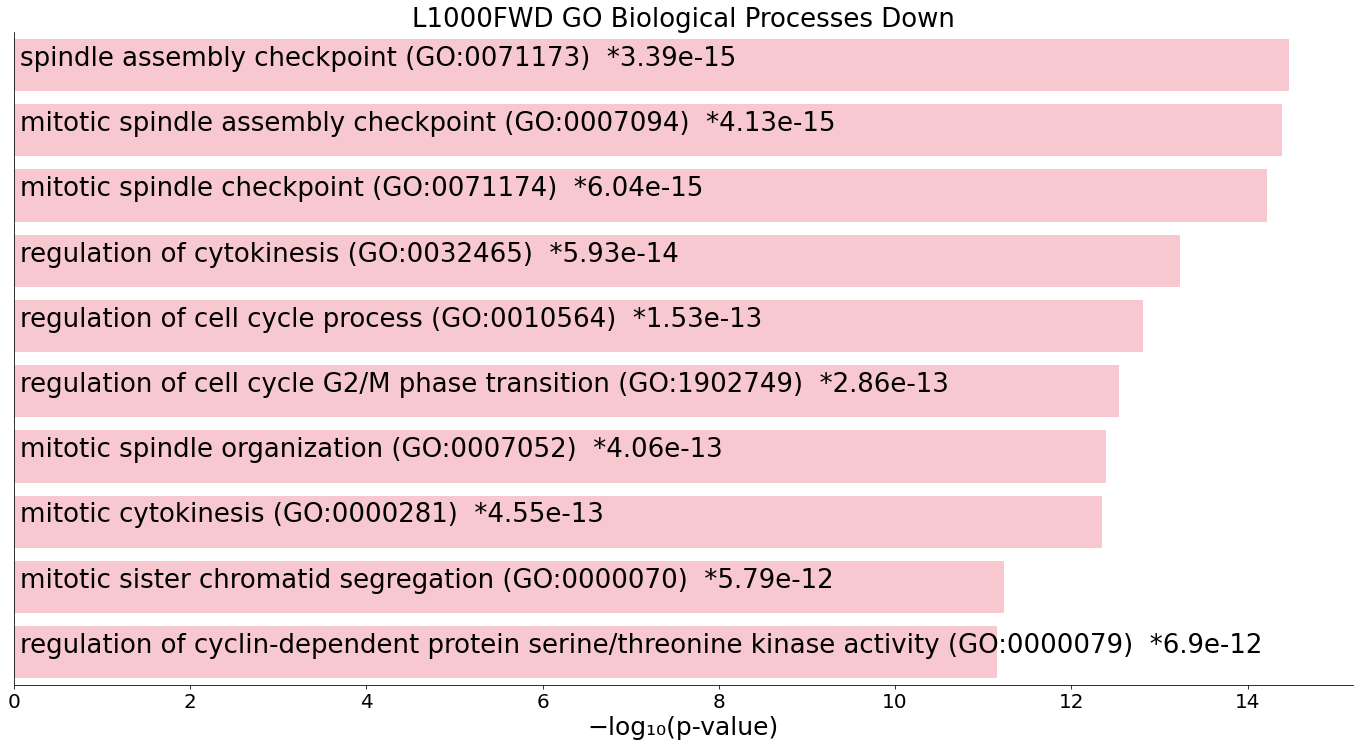

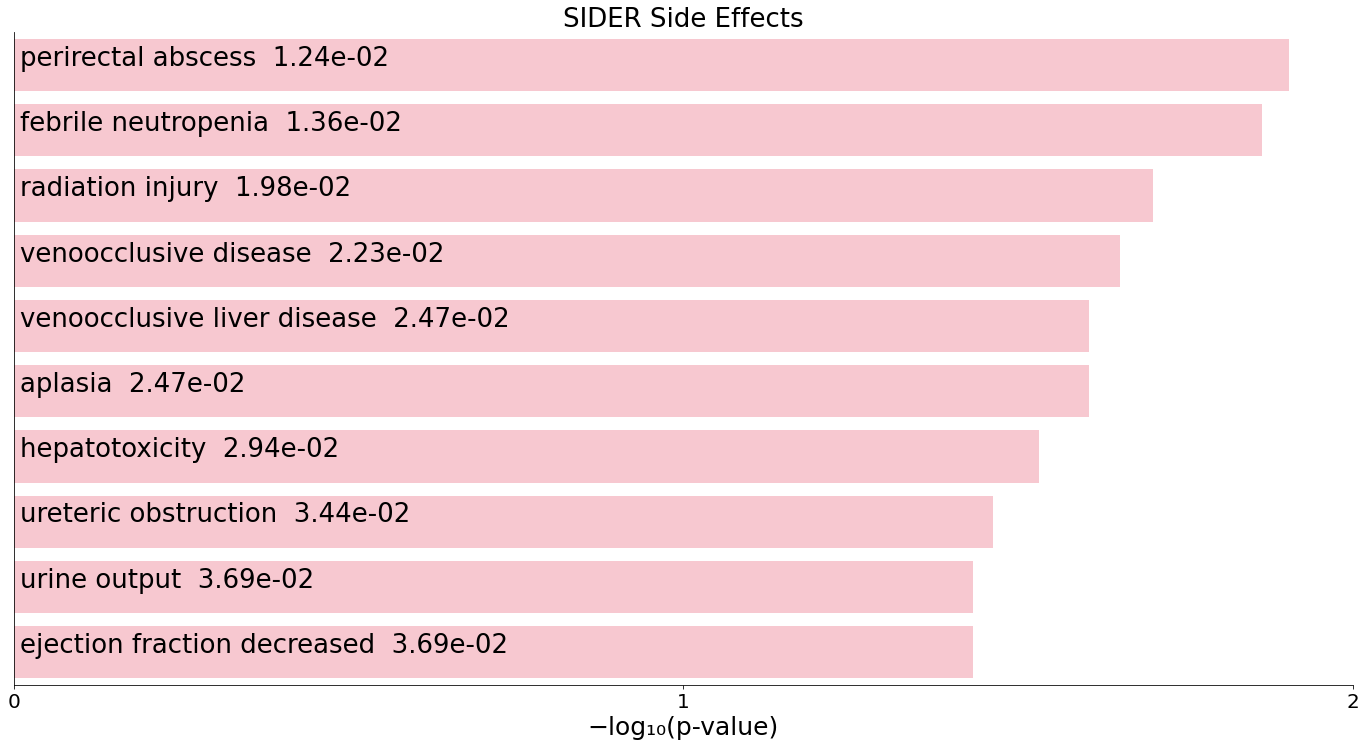

In [15]:
drug_list = predicted_table.index[0:50].tolist()
results = DrugEnrichr_API(drug_list,'%s (DrugShot L1000 Signature Similarity)'% 'Lung Cancer')
bar_plot(results)

**Link to the complete enrichment analysis results is output below**

In [16]:
drugenrichr_link(short_id)